In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

def load_inputs():
    # Open and read the “in” Matlab file
    inputs = scipy.io.loadmat(r'.\data\in.mat')

    # Get inputs as numpy array
    inputs = inputs['in']

    return inputs

In [3]:
# Read data
inputs = load_inputs()
#traces = load_traces()

# 2000 4-bit inputs used in the attack 
no_inputs = np.shape(inputs)[0]

# 14900 traces of 6990 time samples each
#no_traces = np.shape(traces)[0]

#assert(no_traces == no_inputs)

# Hardcode here the number of power traces to run the attack with
# no_inputs = 500

# Keep only the first 500 traces
# traces = traces[:no_inputs]

In [ ]:
# Generate a random number r0, between 0 and 15

# import the random module
import random

r0 = (random.randint(0,15))

In [ ]:
# Splitting phase
# Split in into in0 and in1
in0 = r0
in1 = (in ^ r0)

In [6]:
# Key addition phase
# Creating x1 and x2
x0 = r0
x1 = (in1 ^ key)

In [ ]:
# Substitution phase- Part1
# Defining A:
def A(x0 , x1):
    return A[x0 + x1]

In [7]:
# 4-bit to 4-bit S-box in PRESENT cipher
#       0   1   2   3   4   5   6   7   8   9   a   b   c   d   e   f
sbox= (0xc,0x5,0x6,0xb,0x9,0x0,0xa,0xd,0x3,0xe,0xf,0x8,0x4,0x7,0x1,0x2)

In [ ]:
# Substitution phase- Part2
# Defining B:
def B()
# maps an 8-bit input to a 4-bit output. It receives x0; x1
# Returns the output of the SBox XORed with the output of the substitution phase part 1
def SBox(x0 , x1):
    return (sbox[x0 ^ x1] ^ A())

#### Construct the power-prediction matrix (hypothetical power consumption), by applying Hemming Weight to the value-prediction matrix values. 
Value-prediction matrix on variable y: No_inputs X No_keys.
Save the hypothetical values for each associated plaintext (input) with each possible guess (16 guesses in total).

In [9]:
def get_power_prediction_matrix(no_inputs):
    # Initialize power prediction matrix
    power_pred = np.zeros(shape=(no_inputs, 16))

    for i in range(no_inputs):
        for key in range(0, 16):
            power_pred[i][key] = HammingWeight[SBox(inputs[i][0], key)]

    np.shape(power_pred)  
    
    return power_pred

In [10]:
power_pred = get_power_prediction_matrix(no_inputs)

In [11]:
power_pred

array([[2., 2., 2., ..., 3., 1., 1.],
       [2., 3., 4., ..., 0., 2., 3.],
       [3., 2., 1., ..., 2., 3., 2.],
       ...,
       [3., 2., 2., ..., 1., 3., 1.],
       [2., 3., 4., ..., 0., 2., 3.],
       [3., 1., 1., ..., 2., 3., 2.]])

#### For all possible k candidates, compute the column-wise correlation between the traces matrix and the power-prediction matrix. Every guess will be compared to all traces.
#### Pearson Correlation Formula:
$ r = \frac{{}\sum_{i=1}^{n} (h_i - \overline{h})(t_i - \overline{t})}
{\sqrt{\sum_{i=1}^{n} (h_i - \overline{t})^2(t_i - \overline{t})^2}} $

Where: 
    <ul>
    <li> i - i iterates over the traces </li>
    <li> h - hypothetical values (from power prediction matrix) </li>
    <li> t - trace values (traces/ measurement matrix) </li>
    </ul>

We will use numpy.corrcoef to obtain the Pearson correlation coefficients.
Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html

In [12]:
def correlate_traces_with_hypotheses(traces, power_pred):
    no_col_traces = np.shape(traces)[1]
    no_col_power_pred = 16 # 16 key guesses (0..15)
    
    correlation = np.zeros(shape=(no_col_power_pred, no_col_traces))
    
    # Compute correlation between columns
    for power_pred_col in range(no_col_power_pred): # hypothetical values for the guess keys
        for traces_col in range(no_col_traces): # real values
            correlation[power_pred_col, traces_col] = np.corrcoef(power_pred[:,power_pred_col], traces[:,traces_col], rowvar=1)[0][1]
            
    return correlation   

In [13]:
# traces 14900 X 6990
np.shape(traces)
# power_pred 149000 X 16
np.shape(power_pred)

# absolute candidates 16 X 6990
abs_candidates = abs(correlate_traces_with_hypotheses(traces, power_pred))

In [14]:
abs_candidates

array([[0.03348783, 0.03800449, 0.00253007, ..., 0.03427277, 0.01495866,
        0.0208912 ],
       [0.04762932, 0.04429132, 0.04219041, ..., 0.00041161, 0.00467283,
        0.02385718],
       [0.00198881, 0.02449621, 0.00028099, ..., 0.01231714, 0.02471744,
        0.00895936],
       ...,
       [0.04978649, 0.02209946, 0.0052512 , ..., 0.04074536, 0.02702487,
        0.01288819],
       [0.05429487, 0.04169866, 0.03440161, ..., 0.01664969, 0.04265499,
        0.03357413],
       [0.01178389, 0.04569755, 0.03811546, ..., 0.03689632, 0.01919994,
        0.00853636]])

In [15]:
def get_top_candidate(candidates):       
    # The top candidate will be chosen based on absolute correlation.
    # The highest correlation reveals the actual KEY.
    candidates_max = np.zeros(16)
    
    # Only store the maximum cpa across all points in the trace 16 X 1
    for i in range(16):
        candidates_max[i] = max(candidates[i])
        
    # Rank the key candidates from best to worst, based on the absolute value of the correlation function.
    print('Top candidates: ', candidates_max.argsort()[::-1][:])
    
    # The highest correlation value reveals the key
    top_candidate_row = np.argmax(candidates_max)
    
    return top_candidate_row

In [16]:
top_candidate = get_top_candidate(abs_candidates)

Top candidates:  [11  0  2 15 12  8  4  5 13  7  9 14  3 10  6  1]


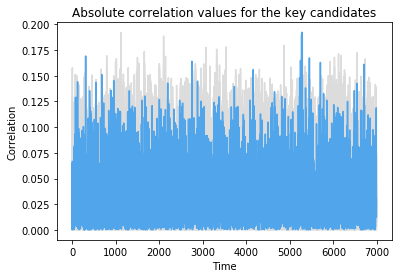

In [17]:
# For every time sample, plot the absolute correlation value for every k candidate
plt.figure()

for i in range(np.shape(abs_candidates)[0]): # 16 candidate keys
        if (i == top_candidate):
            plt.plot(abs_candidates[i], color= '#51A5EB', zorder=2)
        else:
            plt.plot(abs_candidates[i], color = '#DCDCDC', zorder=1)
        
plt.title("Absolute correlation values for the key candidates")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()

In [47]:
def get_top_candidate_ranking(candidates):       
    # The top candidate will be chosen based on absolute correlation.
    # The highest correlation reveals the actual KEY.
    candidates_max = np.zeros(16)
    
    # Only store the maximum cpa across all points in the trace 16 X 1
    for i in range(16):
        candidates_max[i] = max(candidates[i])
        
    # Rank the key candidates from best to worst, based on the absolute value of the correlation function.
    best_to_worse = candidates_max.argsort()[::-1][:]
    print('Top candidates: ', best_to_worse)
    
    # ranking between 1 and 16 (add 1 to the position of the best candidate, which is 6)
    top_candidate_ranking = np.where(best_to_worse == 6)[0] + 1 
    
    return top_candidate_ranking

In [48]:
def run_attack(no_inputs, inputs, traces):
    # Keep only the first no_inputs traces
    traces = traces[:no_inputs]
    
    power_pred = get_power_prediction_matrix(no_inputs)
    
    # absolute candidates 16 X 6990
    abs_candidates = abs(correlate_traces_with_hypotheses(traces, power_pred))
    
    top_candidate_ranking = get_top_candidate_ranking(abs_candidates)
    
    return top_candidate_ranking

In [49]:
# Run the attack with 500, 1k, 2k 4k, 8k and 12k power traces
# For every attack, rank the candidates from best to worst. 
# Plot the correct candidate’s ranking (e.g. 1st, 2nd etc.) for all these attacks.

# Read data
inputs = load_inputs()
traces = load_traces()

# 14900 4-bit inputs used in the attack 
no_inputs = np.shape(inputs)[0]

# 14900 traces of 6990 time samples each
no_traces = np.shape(traces)[0]

assert(no_traces == no_inputs)

# Hardcode here the number of power traces to run the attack with
no_inputs_att = (500, 1000, 2000, 4000, 8000, 12000)

rankings = []

for no_inputs_attack in no_inputs_att:
    top_candidate_ranking = run_attack(no_inputs_attack, inputs, traces)
    
    rankings.append(top_candidate_ranking[0])

    print('No_inputs ', no_inputs_attack, ':', top_candidate_ranking[0])

Top candidates:  [11  0  2 15 12  8  4  5 13  7  9 14  3 10  6  1]
No_inputs  500 : [15]
Top candidates:  [ 2 13 11 12  4  1  0  3 14 15  8  9  5  7 10  6]
No_inputs  1000 : [16]
Top candidates:  [ 0  7  4 13  1 15  9 12 11  3 10  8 14  5  6  2]
No_inputs  2000 : [15]
Top candidates:  [13 12  7 14  9  5 11 15  6  2  4  1  0 10  8  3]
No_inputs  4000 : [9]
Top candidates:  [ 7  6  2  1  0 15  8  4  5 10  3  9 14 11 12 13]
No_inputs  8000 : [2]
Top candidates:  [ 6  5 12  3  4  1 13  0 10  2 11  9 15 14  8  7]
No_inputs  12000 : [1]


In [50]:
rankings

[15, 16, 15, 9, 2, 1]

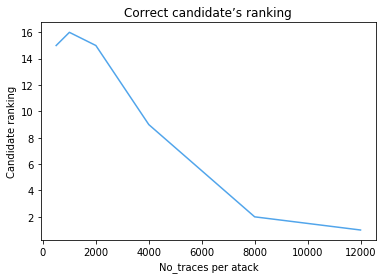

In [51]:
# Plot the correct candidate’s ranking (e.g. 1st, 2nd etc.) for all these attacks.
# For every time sample, plot the absolute correlation value for every k candidate
plt.figure()

plt.plot(no_inputs_att, rankings, color= '#51A5EB', zorder=2)
        
plt.title("Correct candidate’s ranking")
plt.xlabel("No_traces per atack")
plt.ylabel("Candidate ranking")
plt.show()